# Emperical Orthogonal Functions

In [ ]:
import os, sys
import pandas as pd
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
#source activate MyEnvironment
#conda install basemap
#import mpl_toolkits
#mpl_toolkits.__path__.append('/usr/lib/python2.7/dist-packages/mpl_toolkits/')
#from mpl_toolkits.basemap import Basemap
import xarray as xr
from netCDF4 import Dataset
import cartopy
import xarray as xr
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import integrate
from sklearn.decomposition import PCA as RandomizedPCA

In [10]:
# open dataset
am_HM_asia_HADM3 = xr.open_dataset('output/am_HM_asia_HADM3.nc')
am_HM_bang_HADM3 = xr.open_dataset('output/am_HM_bang_HADM3.nc')

### Plot spatial graphs first of temporal action measure

In [11]:
def plot_spatial_figures(am_daily, extent):
    raph = am_daily['actionmeasure']
    lat = am_daily.variables['lat'][:]
    lon = am_daily.variables['lon'][:]
    am = am_daily.actionmeasure.isel(time = 1972)
    time = am_daily.variables['time'][:]
    print(time[1972])
    
    over_time = raph.mean(dim = 'time')
    count_am = raph.where(raph > 0)
    count_am = count_am.dropna(dim = 'time')
    count_am = count_am.count(dim='time')
    std = raph.std(dim = 'time')
    max_plt = raph.max(dim = 'time')
    
    fig = plt.figure(figsize = (20,10))
    
    ax1 = fig.add_subplot(221, projection = cartopy.crs.PlateCarree())
    p1 = ax1.pcolormesh(lon, lat, am.T, cmap = 'Reds', transform = cartopy.crs.PlateCarree())
    ax1.set_extent(extent)
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
    cb1 = plt.colorbar(p1, shrink=0.5)
    plt.title('Action measure at specific day')
    
    ax2 = fig.add_subplot(222, projection = cartopy.crs.PlateCarree())
    am = over_time
    p2 = ax2.pcolormesh(lon, lat, am.T, cmap = 'Reds', transform = cartopy.crs.PlateCarree())
    ax2.set_extent(extent)
    ax2.add_feature(cartopy.feature.COASTLINE)
    ax2.add_feature(cartopy.feature.BORDERS, linestyle='-')
    cb2 = plt.colorbar(p2, shrink=0.5)
    cb2.ax.set_ylabel('Action measure in $^\circ$C*day', rotation=90)
    plt.title('Mean of action measure over time')

#     ax3 = fig.add_subplot(223, projection = cartopy.crs.PlateCarree())
#     p3 = ax3.pcolormesh(lon, lat, count_am.T, cmap = 'Reds', transform = cartopy.crs.PlateCarree())
#     ax3.set_extent(extent)
#     ax3.add_feature(cartopy.feature.COASTLINE)
#     ax3.add_feature(cartopy.feature.BORDERS, linestyle='-')
#     cb3 = plt.colorbar(p3, shrink=0.5)
#     cb3.ax.set_ylabel('Amount of events', rotation=90)
#     plt.title('Amount of extreme events')

    ax3 = fig.add_subplot(223, projection = cartopy.crs.PlateCarree())
    am = max_plt
    p3 = ax3.pcolormesh(lon, lat, am.T, cmap = 'Blues', transform = cartopy.crs.PlateCarree())
    ax3.set_extent(extent)
    ax3.add_feature(cartopy.feature.COASTLINE)
    ax3.add_feature(cartopy.feature.BORDERS, linestyle='-')
    cb3 = plt.colorbar(p3, shrink=0.5)
    cb3.ax.set_ylabel('Action measure in $^\circ$C*day', rotation=90)
    plt.title('Maximum value of action measure')


    ax4 = fig.add_subplot(224, projection = cartopy.crs.PlateCarree())
    p4 = ax4.pcolormesh(lon, lat, std.T, cmap = 'YlGn', transform = cartopy.crs.PlateCarree())
    ax4.set_extent(extent)
    ax4.add_feature(cartopy.feature.COASTLINE)
    ax4.add_feature(cartopy.feature.BORDERS, linestyle='-')
    cb4 = plt.colorbar(p4, shrink=0.5)
    cb4.ax.set_ylabel('Standard deviation in $^\circ$C*day', rotation=90)
    plt.title('Standard deviation')

In [ ]:
bang_extent = [86, 95, 20, 27]
asia_extent = [70, 115, 8, 30]
world_extent = [0, 360, -90, 90]

<xarray.Variable ()>
array(cftime.Datetime360Day(1955, 6, 23, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Attributes:
    standard_name:  time
    axis:           T


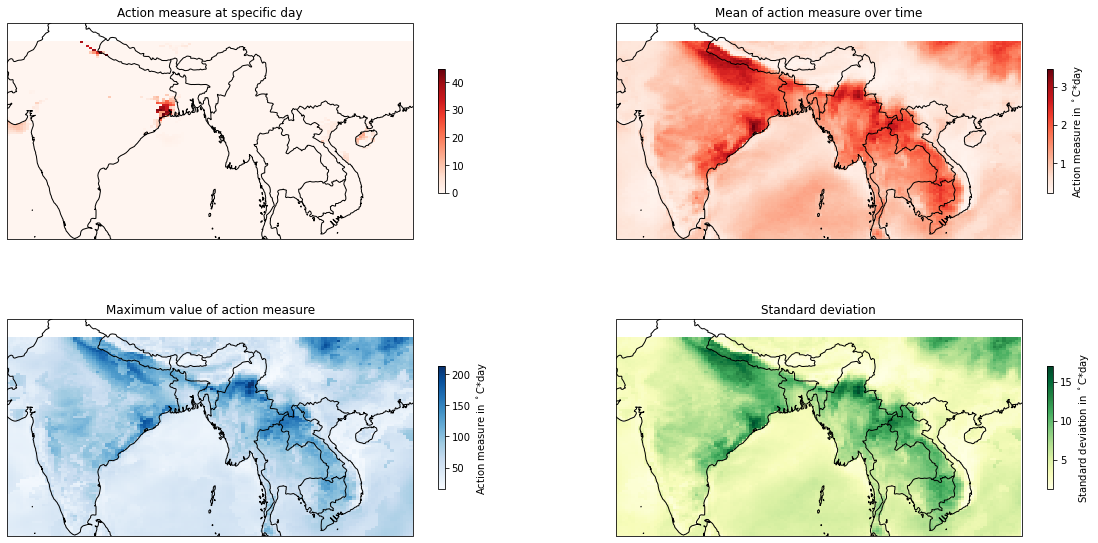

In [12]:
plot_spatial_figures(am_HM_asia_HADM3, asia_extent)

<xarray.Variable ()>
array(cftime.Datetime360Day(1955, 6, 23, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Attributes:
    standard_name:  time
    axis:           T


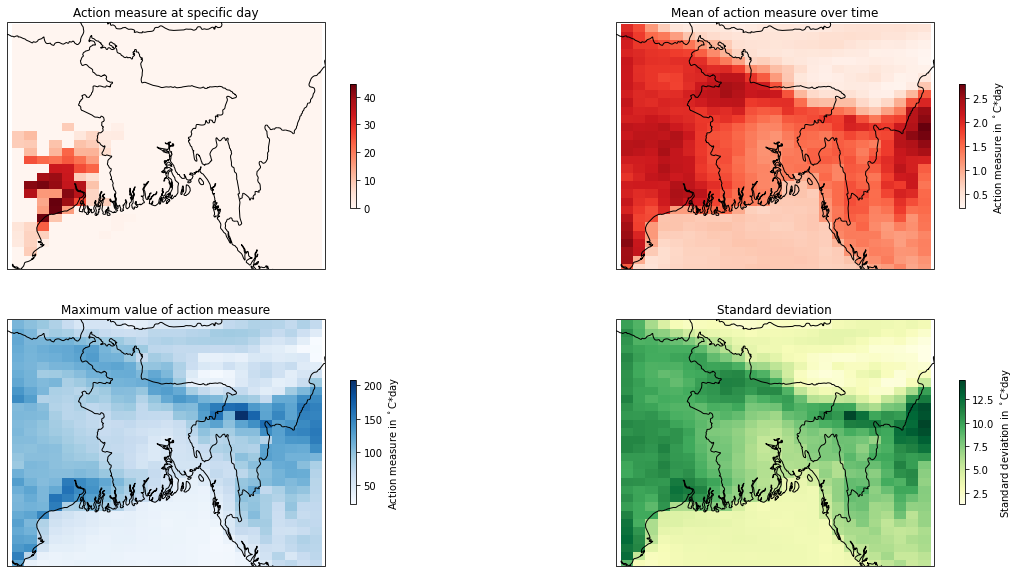

In [13]:
plot_spatial_figures(am_HM_bang_HADM3, bang_extent)

### Start PCA analysis

In [18]:
def plot_eofs(m, X, lats, lons, vmin, vmax, step, cmap=plt.get_cmap('jet'), \
               ax=False, title=False, grid=False):
    f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    m.drawmeridians(np.arange(0, 360, 5), labels=[0,0,0,1])
    m.drawparallels(np.arange(-80, 80, 5), labels=[1,0,0,0])
    m.colorbar(im)
    #ax.set_title(title)

In [19]:
def EOF_analysis(am_daily):
    lat = am_daily['lat'].values
    lon = am_daily['lon'].values
    am = am_daily['actionmeasure'].values.squeeze()
    
    # change time, lon, lat dimension to time, space
    X = np.reshape(am, (am.shape[0], len(lat) * len(lon)), order='F')
    # save current shape of data
    landandocean = X
    
    # Use skleanr fit and transform methods to first scale the data
    from sklearn import preprocessing
    scaler  = preprocessing.StandardScaler()
    scaler_training_am = scaler.fit(X)
    
    X = scaler_training_am.transform(X)
    
    ## perform PCA
    pca = RandomizedPCA(svd_solver='randomized', whiten=True).fit(X)
    
    # Plot principal components
    f, ax = plt.subplots(figsize=(6,6))
    ax.plot(pca.explained_variance_ratio_[0:10]*100)
    ax.plot(pca.explained_variance_ratio_[0:10]*100,'ro')
    
    # calculate number of PCs to explain 70% of variance
    ipc = np.where(pca.explained_variance_ratio_.cumsum() >= 0.70)[0][0]
    
    PCs = pca.transform(X)
    PCs = PCs[:,:ipc]
    
    ## FInd EOFs
    EOFs = pca.components_
    EOFs = EOFs[:ipc,:]
    
    lo = ma.masked_array(landandocean)
    lo = lo.sum(0).mask
    rep = ~lo
    ## Reconstruct the maps
    EOF_recons = np.ones((ipc, len(lat) * len(lon)))* -999

    for i in range(ipc): 
        EOF_recons[i,rep] = EOFs[i,:]

    EOF_recons = np.reshape(EOF_recons, (ipc, len(lat), len(lon)), order='F')
    
    return EOF_recons, PCs

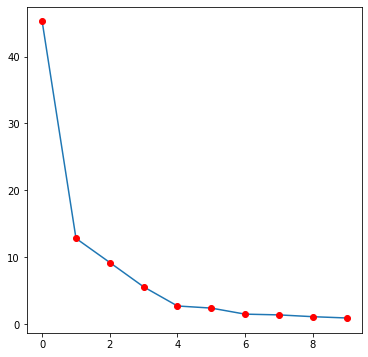

In [20]:
EOFs_bang, PCs_bang = EOF_analysis(am_HM_bang_HADM3)

In [ ]:
plt.imshow(EOFs_bang[0,:,:], origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar();
    
m = bm(projection='cyl',llcrnrlat=lat.min(),urcrnrlat=lat.max(),\
           llcrnrlon=lon.min(),urcrnrlon=lon.max(),\
            lat_ts=0,resolution='c')
    
EOFs_bang *= 100
    
lons, lats = np.meshgrid(lon, lat)
plot_eofs(m, EOF_recons[0,:,:], lats, lons, -30, 30, 0.1, grid=True, cmap=plt.get_cmap('RdBu_r'))

In [ ]:
plot_eofs(m, EOF_recons[1,:,:], lats, lons, -30, 30, 0.1, grid=True, cmap=plt.get_cmap('RdBu_r'))

In [ ]:
plot_eofs(m, EOF_recons[2,:,:], lats, lons, -30, 30, 0.1, grid=True, cmap=plt.get_cmap('RdBu_r'))

In [ ]:
EOFs_asia, PCs_asia = EOF_analysis(am_HM_asia_HADM3)

## Scale and save the PCs

In [ ]:
def scale_PCs(PCS, outputname):
    from sklearn.preprocessing import StandardScaler
    from scipy.signal import detrend
    scaler_PCs = StandardScaler()
    scaler_PCs.fit(PCs)
    PCs_std = scaler_PCs.transform(PCs)
    PCdf = pd.DataFrame(PCs_std, index = am_daily['time'], \
                    columns = ["EOF%s" % (x) for x in range(1, PCs_std.shape[1] +1)])
    PCdf.to_csv(outputname)
    
    f, ax = plt.subplots(figsize=(10,4))
    PCdf.iloc[:,0].plot(ax=ax, color='k', label='PC1')
    ax.axhline(0, c='0.8')
    #ax.set_xlabel('period', fontsize=18)
    ax.plot(PCdf.index, detrend(PCdf.iloc[:,0].values), 'r',  label='PC1 (trend removed)')
    ax.grid('off')
    ax.legend(loc=1); 

In [ ]:
bang_outputname = 'output_EOFs/am_HM_bang_EOF_PCs.csv'
scale_PCs(PCs_bang, bang_outputname)